# Run pyCisTopic

In [1]:
import os
import pycisTopic
from pycisTopic.cistopic_class import create_cistopic_object
pycisTopic.__version__

'2.0a0'

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [3]:
root_dir = "/tscc/projects/ps-epigen/users/biy022/biccn/data/SNAREdata/"
os.chdir(Path(root_dir) / "scenicplus" / "all")

In [4]:
!mkdir -p pycistopic_outputs

In [5]:
## Some meta information
path_to_blacklist = "/tscc/projects/ps-epigen/users/biy022/scmethylhic/genome/hg38_blacklist.v2.bed.gz"

In [6]:
## Prepare the sample_id pd.Dataframe, not sure if this is necessary
meta_df = pd.read_csv("BICCN_5K_meta.tsv", header=0, sep="\t", index_col=0)
meta_df["sample_id"] = "BICCN_5K"

In [7]:
from scipy import io
atac_count_matrix = io.mmread("BICCN_5K_atac.mtx")

In [8]:
atac_count_matrix

<554228x113924 sparse matrix of type '<class 'numpy.int64'>'
	with 111682179 stored elements in COOrdinate format>

In [9]:
cell_names_tb = pd.read_csv("BICCN_5K_barcodes.tsv", header=None, sep="\t")
cell_names = cell_names_tb[0].tolist()
region_names_tb = pd.read_csv("BICCN_5K_region.tsv", header=None, sep="\t")
region_names = region_names_tb[0].tolist()
region_names = ["{}:{}-{}".format(*x.split("-")) for x in region_names]

In [10]:
cistopic_object = create_cistopic_object(
    fragment_matrix=atac_count_matrix.tocsr(),
    cell_names=cell_names,
    region_names=region_names,
    path_to_blacklist=path_to_blacklist,
    project="BICCN_5K",
    tag_cells=False
)

2024-06-17 11:10:04,172 cisTopic     INFO     Removing blacklisted regions
2024-06-17 11:10:06,607 cisTopic     INFO     Creating CistopicObject
2024-06-17 11:10:10,638 cisTopic     INFO     Done!


In [11]:
cistopic_object.add_cell_data(meta_df)

Columns ['sample_id'] will be overwritten


In [12]:
print(cistopic_object)

CistopicObject from project BICCN_5K with n_cells × n_regions = 113924 × 552321


In [13]:
pickle.dump(
    cistopic_object,
    open("pycistopic_outputs/cistopic_object.pkl", "wb")
)

In [14]:
# dispatch models to different clusters
!mkdir -p pycistopic_slurm/

In [15]:
slurm_script_template = (
    "#!/bin/bash\n"
    "#SBATCH -p condo\n"
    "#SBATCH -q condo\n"
    "#SBATCH -J {0}\n"
    "#SBATCH -N 3\n"
    "#SBATCH -c 12\n"
    "#SBATCH --mem 400G\n"
    "#SBATCH -t 12:00:00\n"
    "#SBATCH -o /tscc/projects/ps-epigen/users/biy022/biccn/data/SNAREdata/scenicplus/all/pycistopic_slurm/{0}.out\n"
    "#SBATCH -e /tscc/projects/ps-epigen/users/biy022/biccn/data/SNAREdata/scenicplus/all/pycistopic_slurm/{0}.err\n"
    "#SBATCH --mail-user biy022@health.ucsd.edu\n"
    "#SBATCH --mail-type FAIL\n"
    "#SBATCH -A csd772\n"
    "\n"
    "set -e\n"
    "source ~/.bashrc\n"
    "conda activate scenicplus\n"
    "\n"
    "cd /tscc/projects/ps-epigen/users/biy022/biccn/analysis/scenicplus/all\n"
    "python3 02.1_mallet_script.py {0} "
    "/tscc/projects/ps-epigen/users/biy022/biccn/data/SNAREdata/scenicplus/all/pycistopic_outputs/cistopic_object.pkl\n"
)

In [16]:
for n_topic in [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]:
    with open("pycistopic_slurm/model_{}_slurm.sh".format(n_topic), "w") as f:
        f.write(slurm_script_template.format(n_topic))

In [17]:
# Run model on clusters

In [18]:
models = []
for file in os.listdir("pycistopic_outputs"):
    if file.startswith("Topic") and file.endswith(".pkl"):
        model = pickle.load(open(os.path.join("pycistopic_outputs/", file), "rb"))
        models.append(model)

/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-17 12:27:36,594	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [19]:
pickle.dump(
    models,
    open("pycistopic_outputs/cistopic_models.pkl", "wb")
)

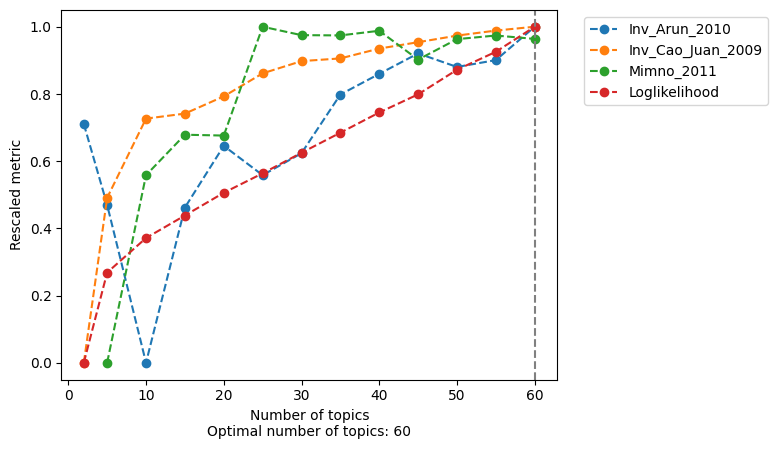

In [20]:
from pycisTopic.lda_models import evaluate_models
model = evaluate_models(models, return_model = True)

In [21]:
cistopic_object.add_LDA_model(model)
pickle.dump(
    cistopic_object,
    open("pycistopic_outputs/cistopic_object.pkl", "wb")
)

## Clustering using cell-topic distribution

In [4]:
cistopic_object = pickle.load(open("pycistopic_outputs/cistopic_object.pkl", "rb"))

/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-17 12:39:57,532	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [5]:
from pycisTopic.clust_vis import (
    find_clusters,
    run_umap,
    run_tsne,
    plot_metadata,
    plot_topic,
    cell_topic_heatmap
)

In [6]:
find_clusters(
    cistopic_object,
    target="cell",
    k=10,
    res=[0.2, 0.4],
    prefix="BICCN_5K_",
    scale=True
)

2024-06-17 12:40:01,229 cisTopic     INFO     Finding neighbours


In [7]:
run_umap(cistopic_object, target="cell", scale=True)

2024-06-17 12:41:25,158 cisTopic     INFO     Running UMAP


/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


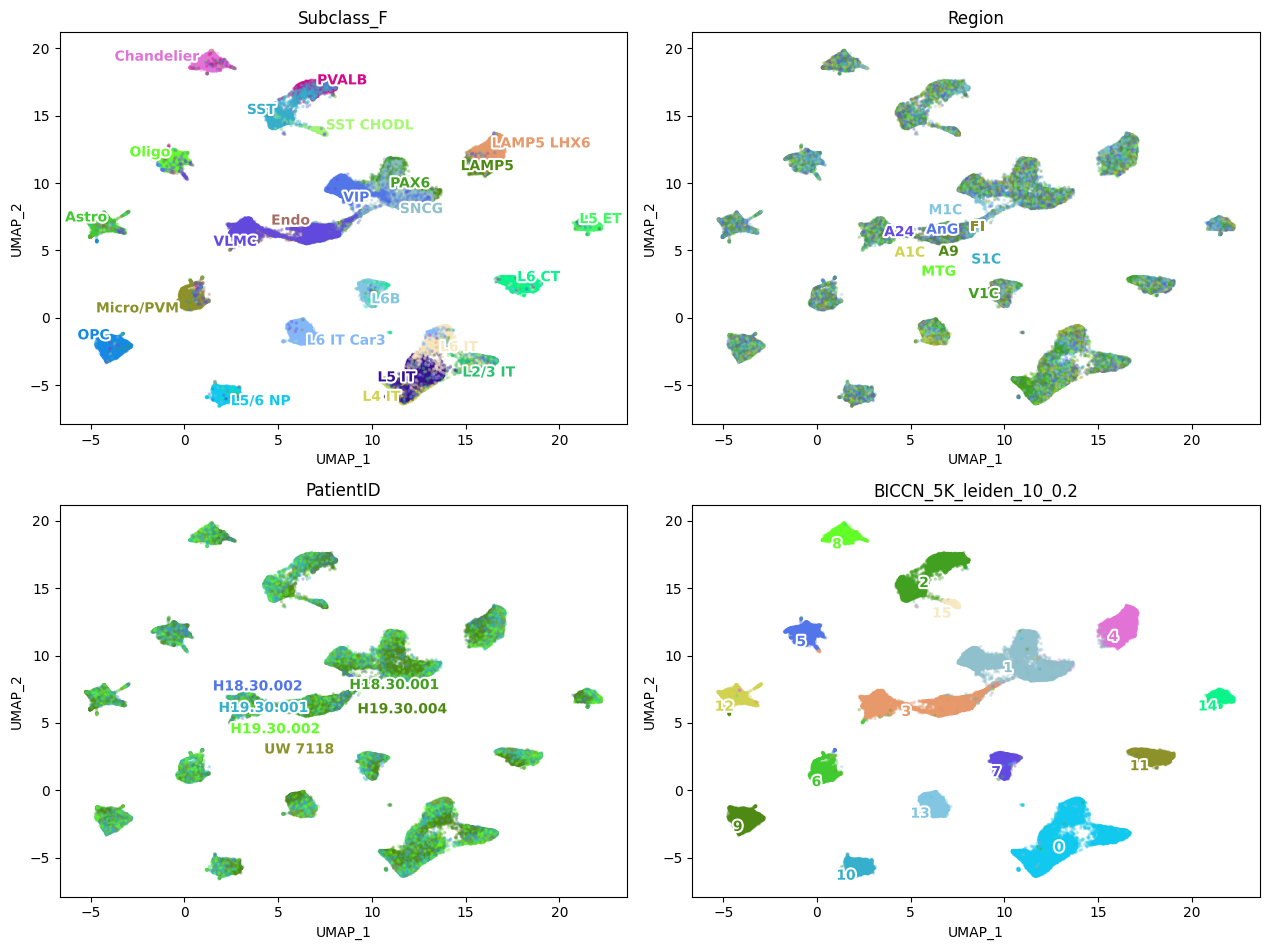

In [8]:
# Some plots for important metadata
plot_metadata(
    cistopic_object,
    reduction_name="UMAP",
    variables=["Subclass_F", "Region", "PatientID", "BICCN_5K_leiden_10_0.2"],
    target="cell", 
    num_columns=2,
    text_size=10,
    dot_size=2.5,
    alpha=0.25
)

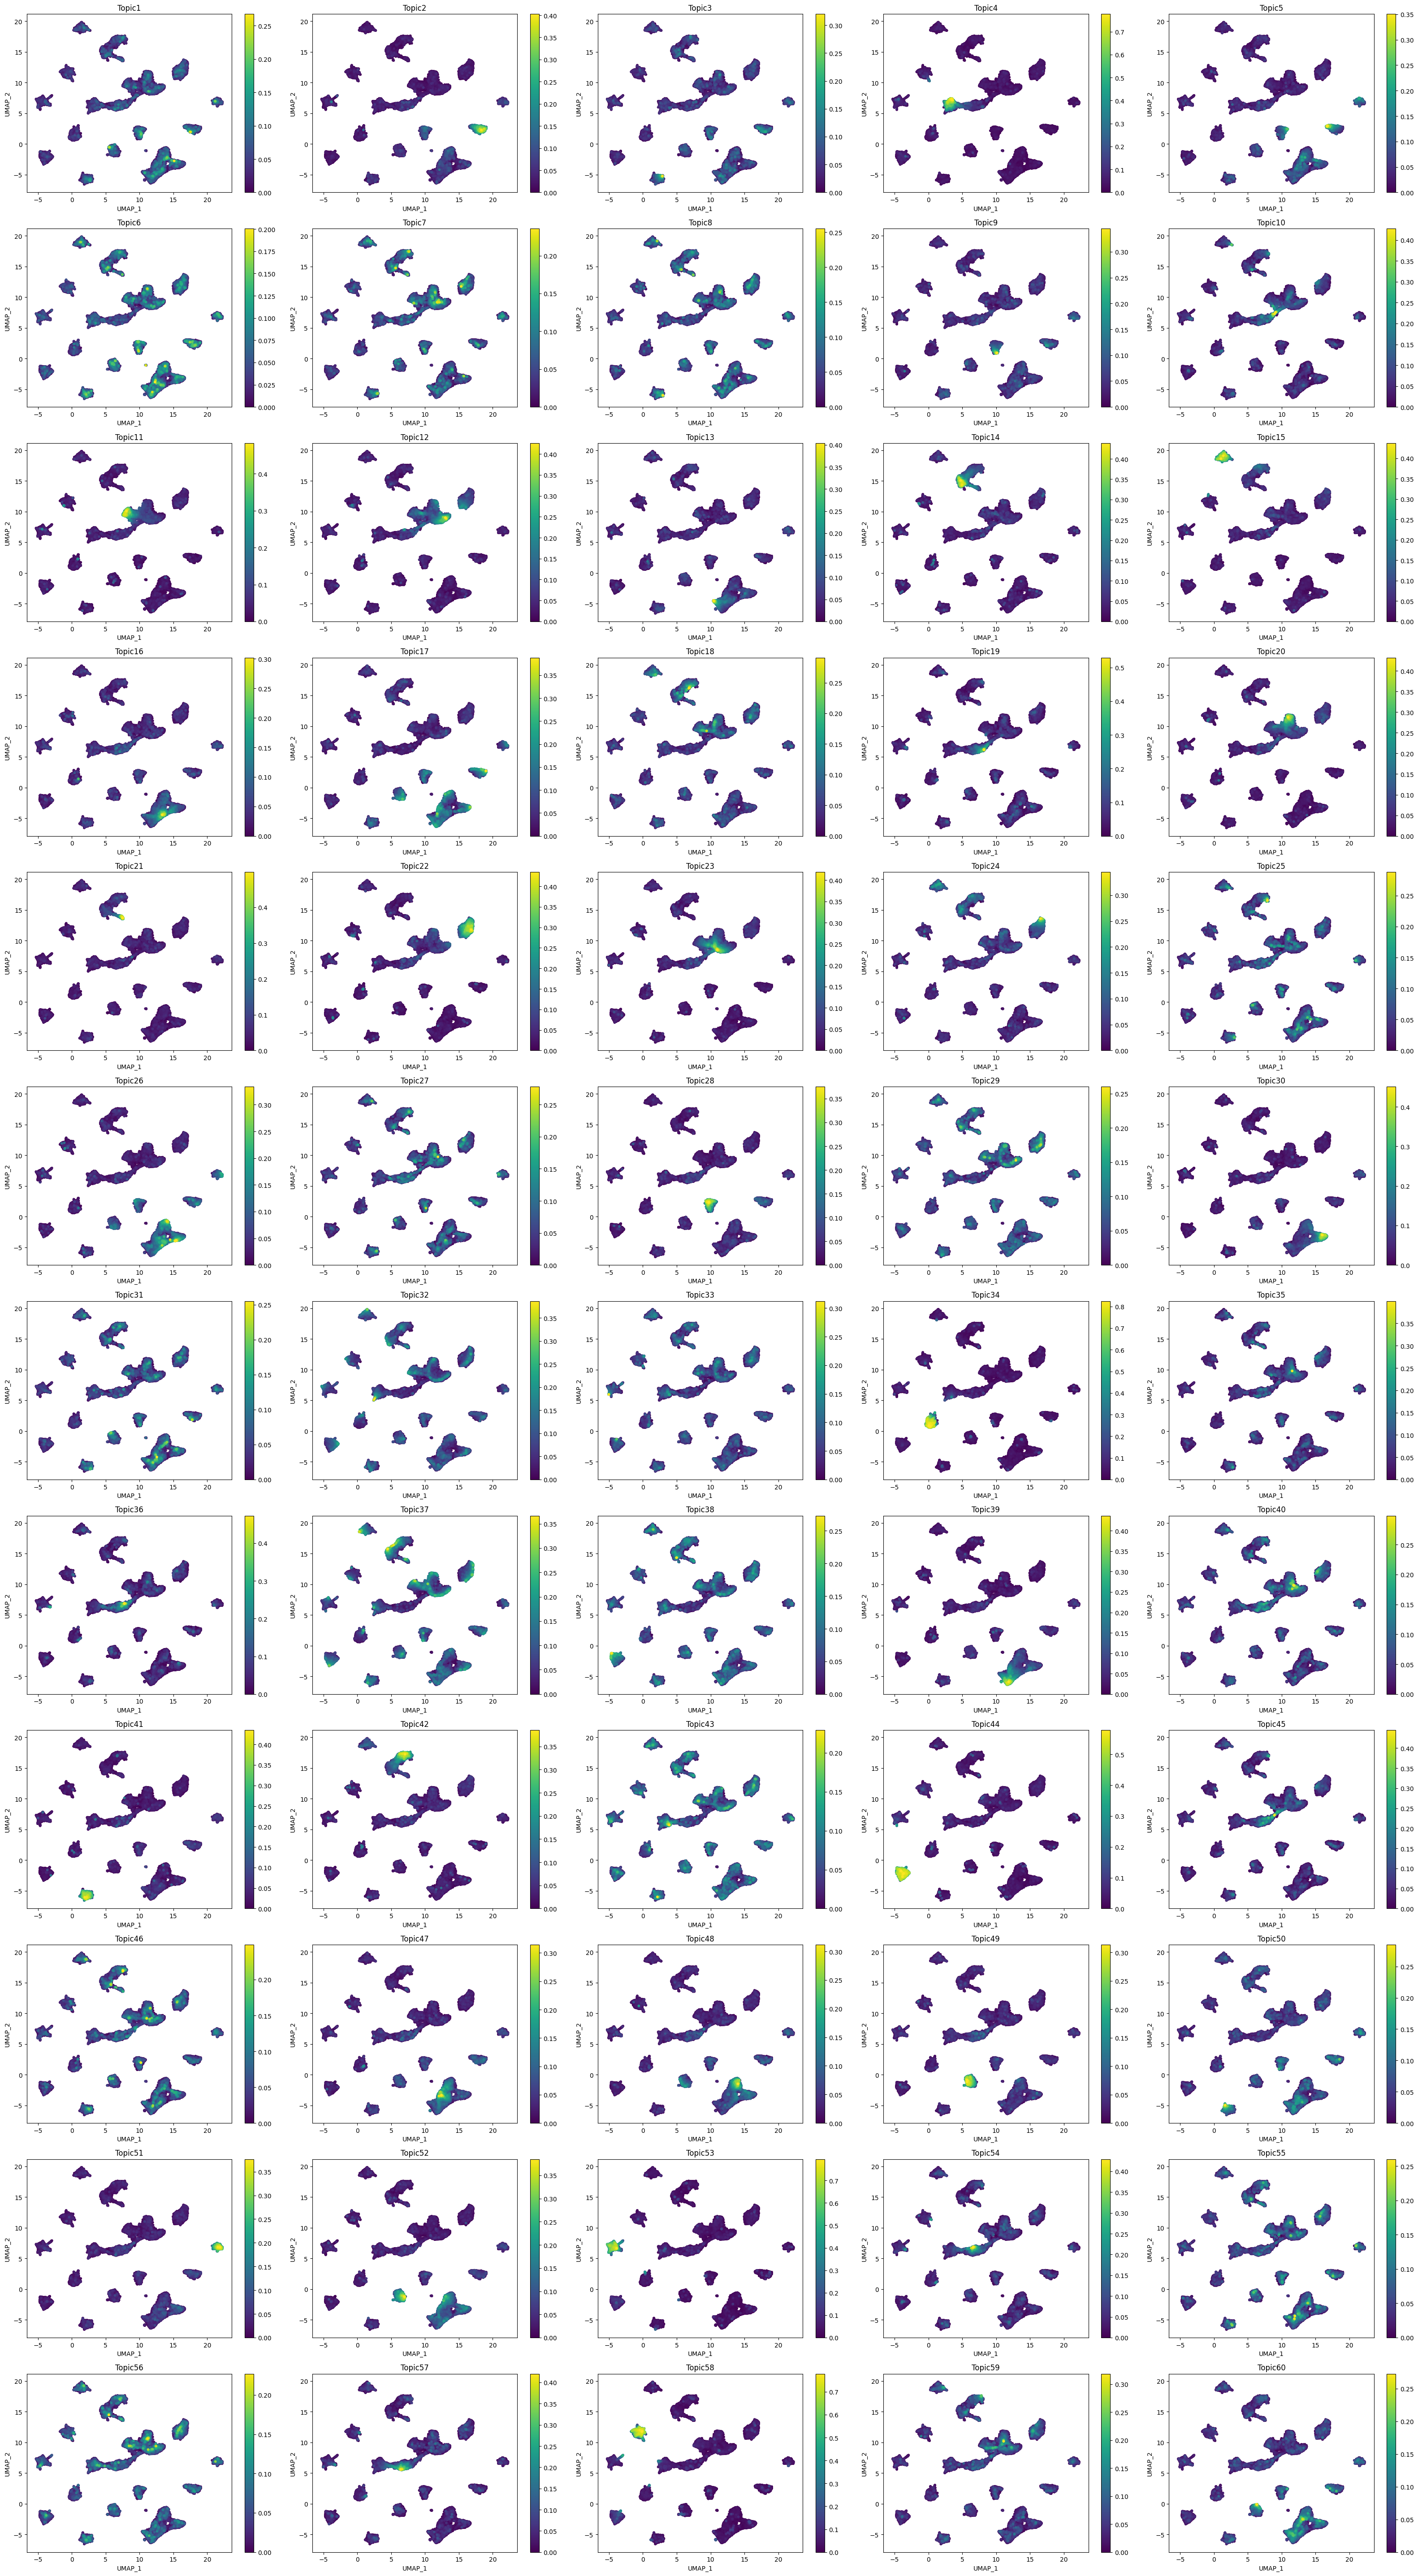

In [9]:
plot_topic(
    cistopic_object,
    reduction_name="UMAP",
    target="cell",
    num_columns=5
)

In [10]:
pickle.dump(
    cistopic_object,
    open("pycistopic_outputs/cistopic_object.pkl", "wb")
)

## Topic binarization

In [4]:
from pycisTopic.topic_binarization import binarize_topics

In [5]:
cistopic_object = pickle.load(open("pycistopic_outputs/cistopic_object.pkl", "rb"))

/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-17 12:45:50,800	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


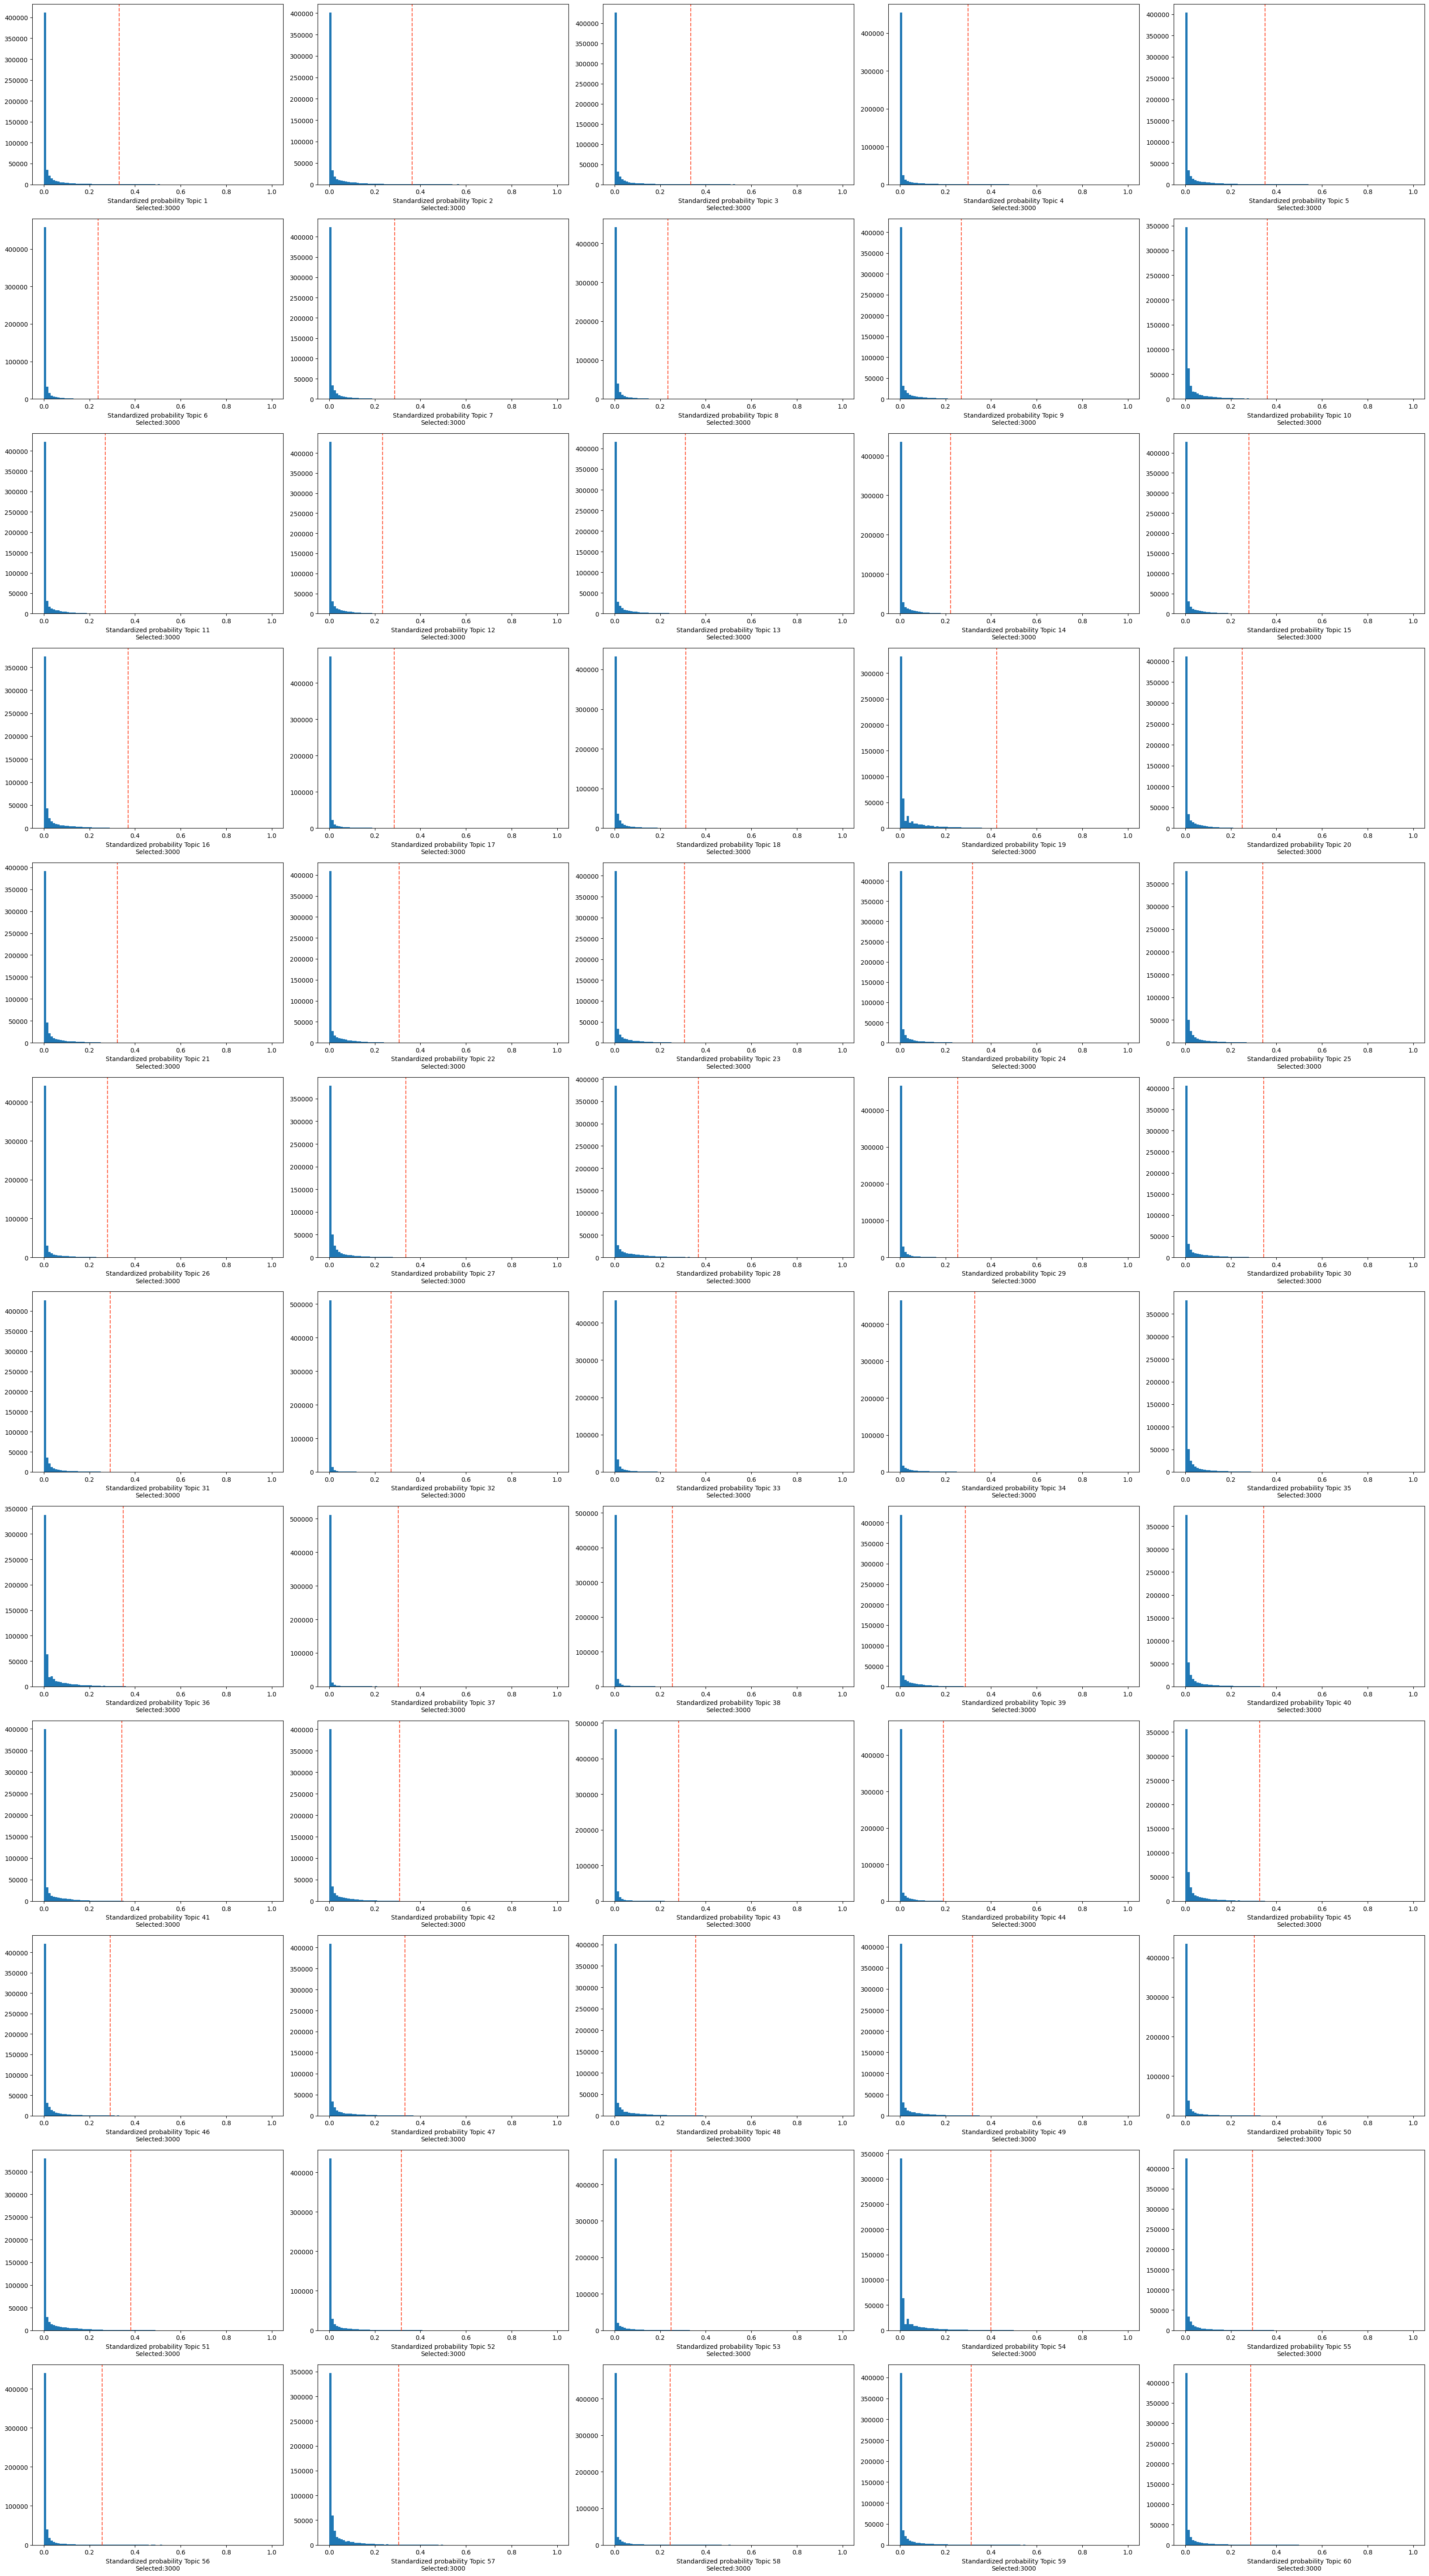

In [6]:
region_bin_topics_top_3k = binarize_topics(
    cistopic_object, method='ntop', ntop=3_000,
    plot=True, num_columns=5
)

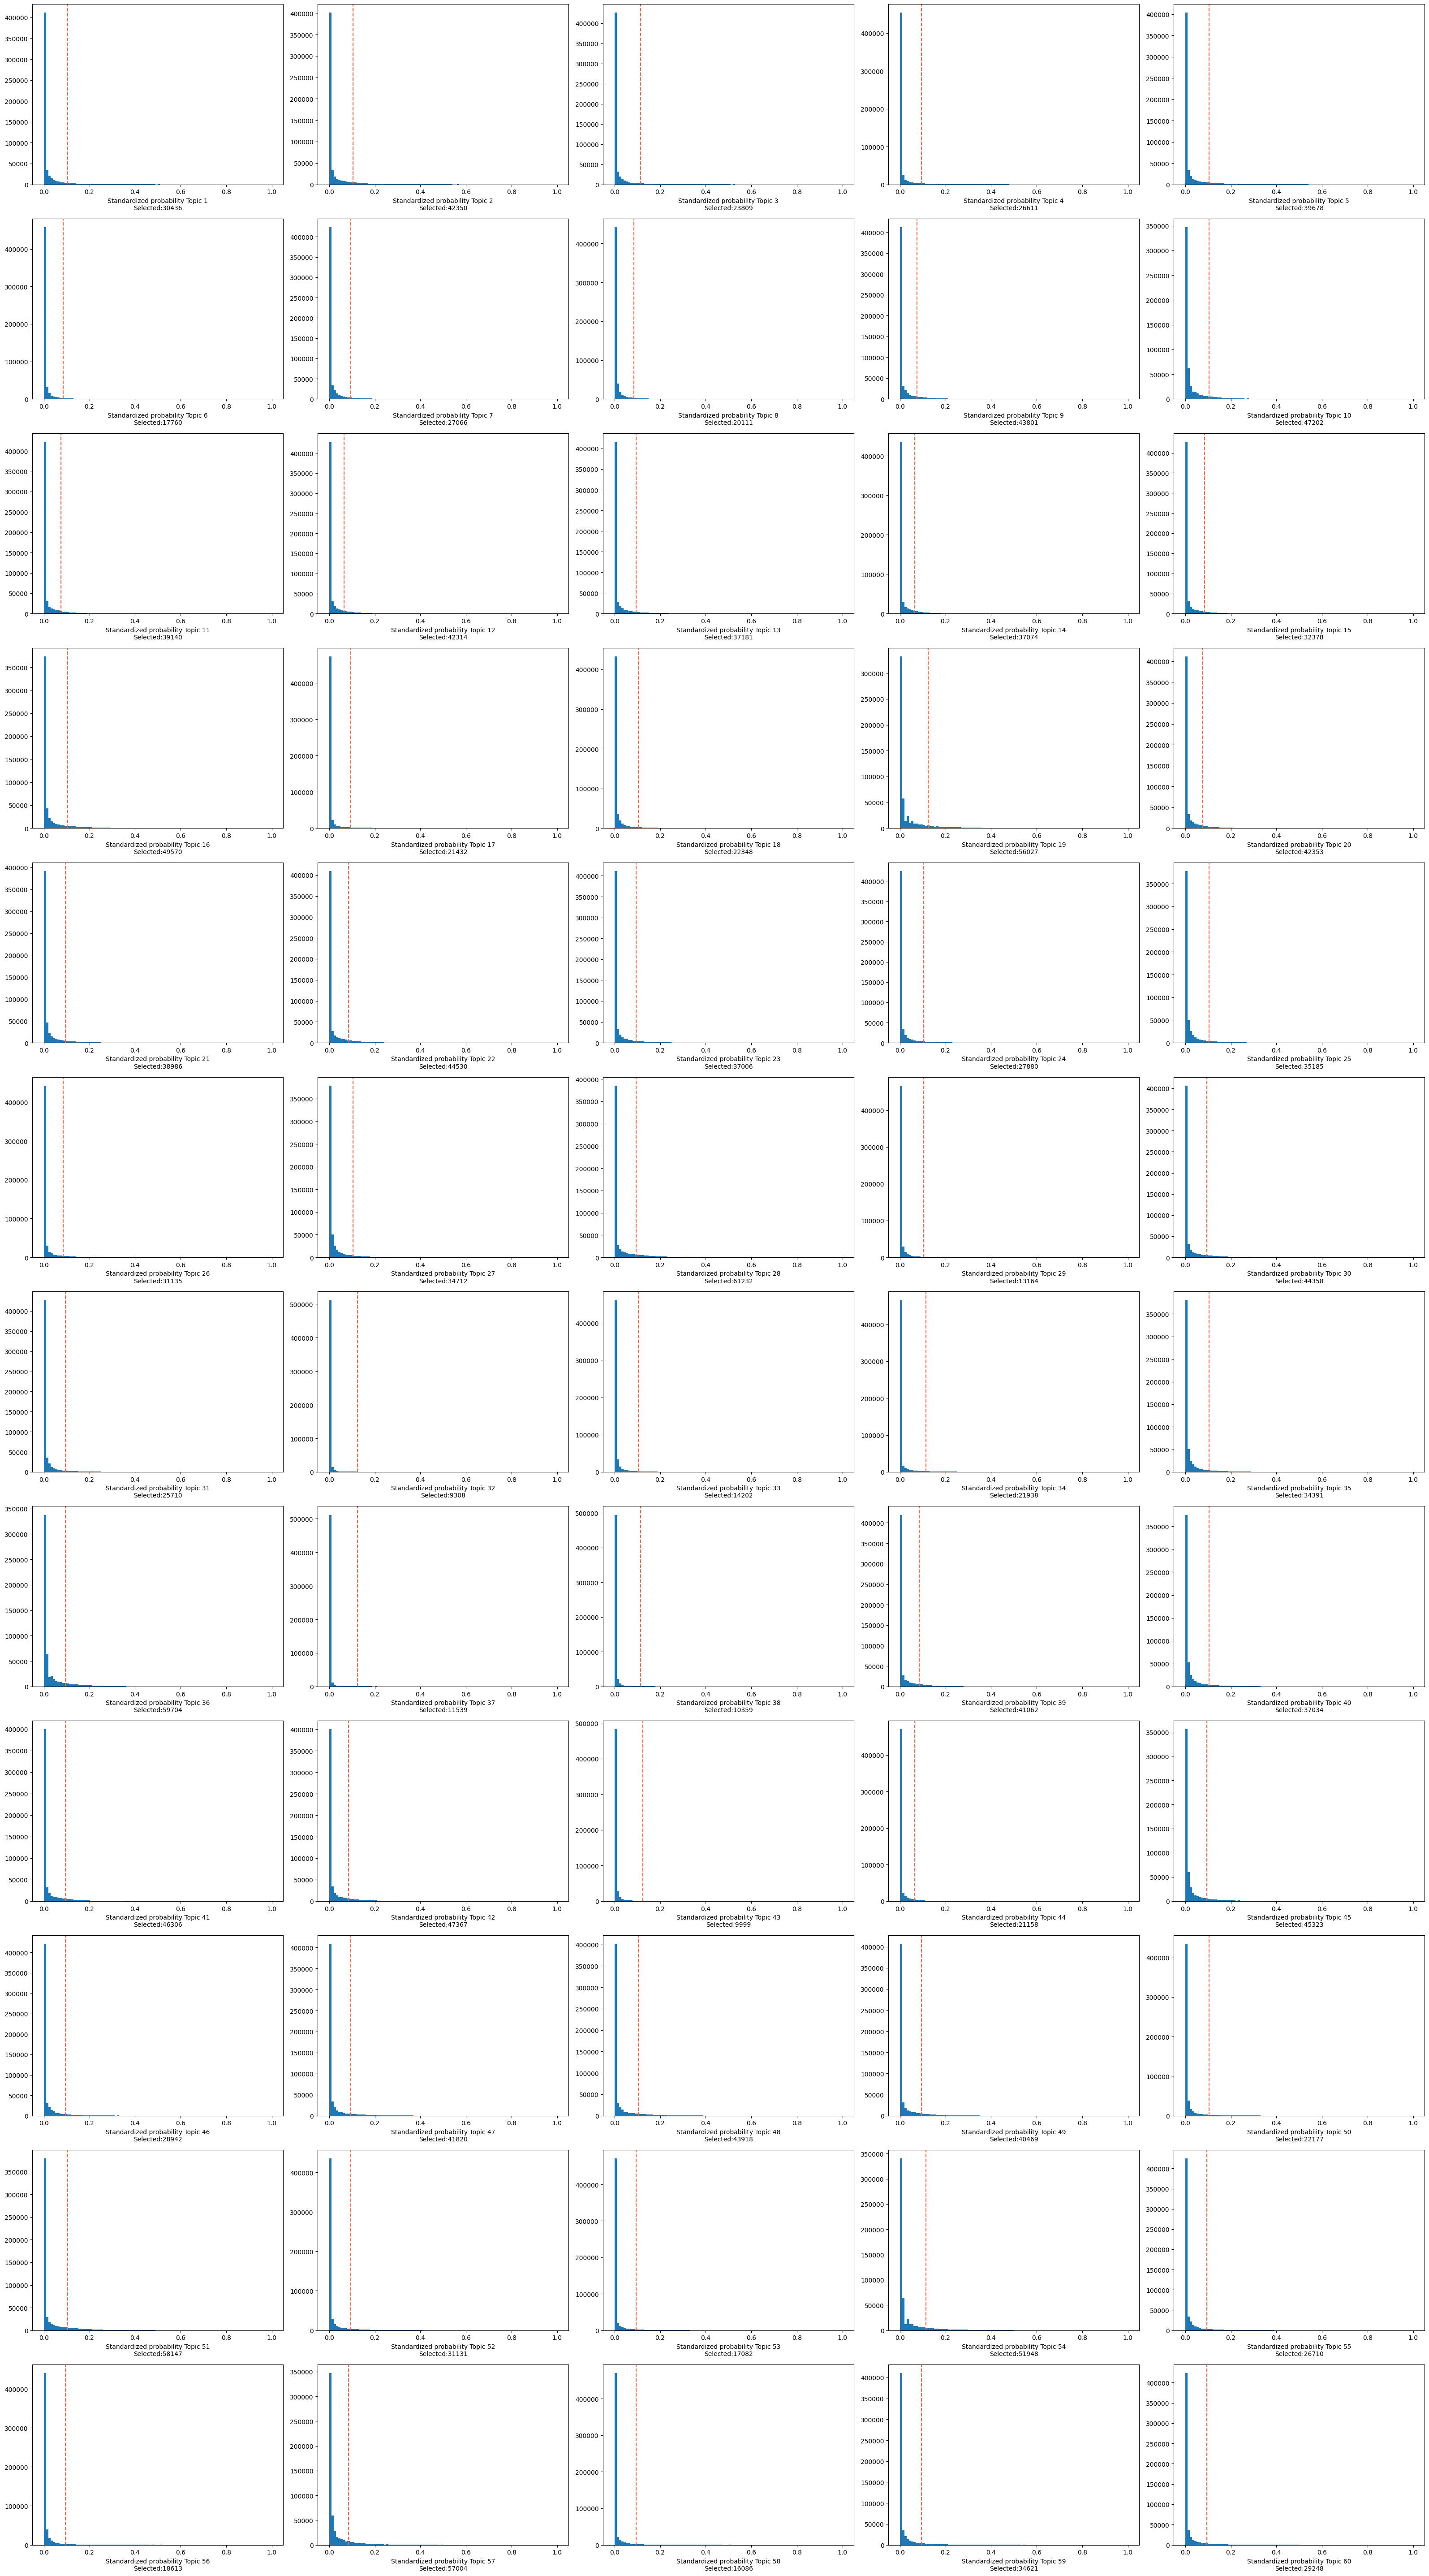

In [7]:
region_bin_topics_otsu = binarize_topics(
    cistopic_object, method="otsu",
    plot=True, num_columns=5
)

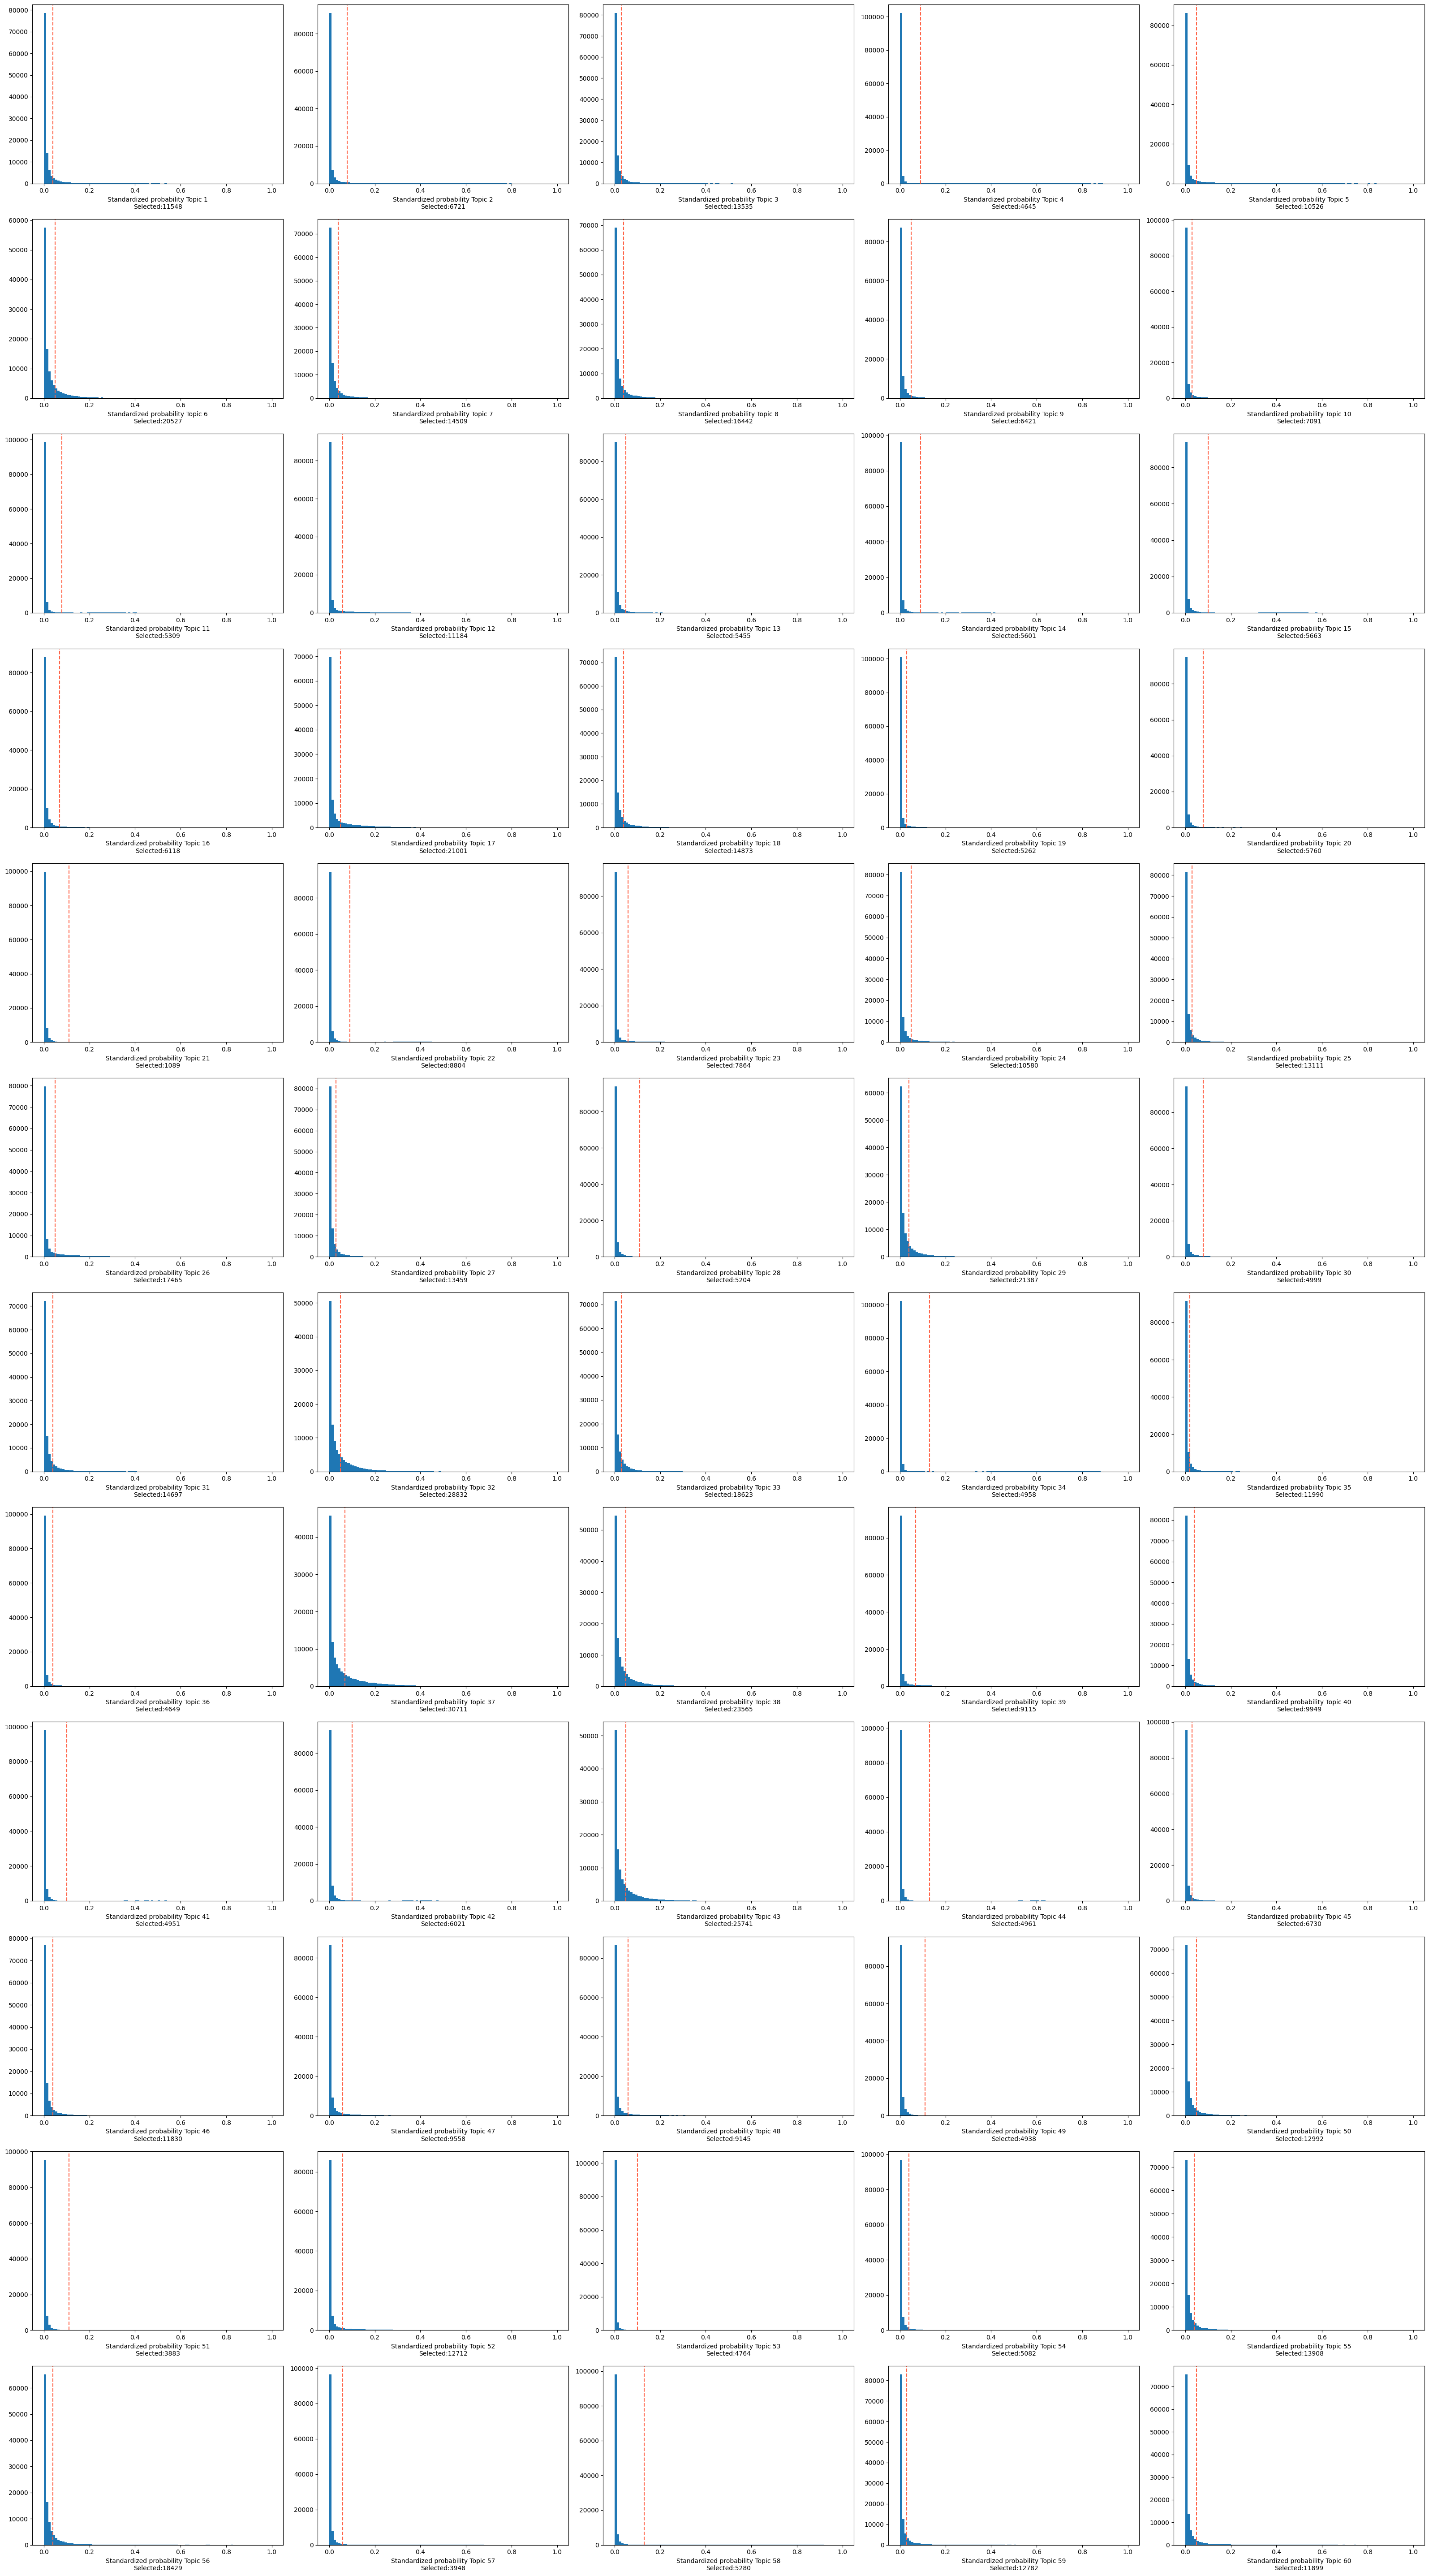

In [8]:
binarized_cell_topic = binarize_topics(
    cistopic_object,
    target="cell",
    method="li",
    plot=True,
    num_columns=5, 
    nbins=100
)

In [9]:
os.makedirs("region_sets", exist_ok=True)
os.makedirs(os.path.join("region_sets", "Topics_otsu"), exist_ok=True)
os.makedirs(os.path.join("region_sets", "Topics_top_3k"), exist_ok=True)

In [10]:
from pycisTopic.utils import region_names_to_coordinates

In [11]:
for topic in region_bin_topics_otsu:
    region_names_to_coordinates(
        region_bin_topics_otsu[topic].index
    ).sort_values(["Chromosome", "Start", "End"]).to_csv(
        os.path.join("region_sets", "Topics_otsu", f"{topic}.bed"),
        sep="\t", header=False, index=False
    )

In [12]:
for topic in region_bin_topics_otsu:
    region_names_to_coordinates(
        region_bin_topics_top_3k[topic].index
    ).sort_values(["Chromosome", "Start", "End"]).to_csv(
        os.path.join("region_sets", "Topics_top_3k", f"{topic}.bed"),
        sep="\t", header=False, index=False
    )